In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FL",
    name= "without batch normalization_FedAvg_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.1,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL":1e-5,
    'num_rounds_FL': 40, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    
    }
)

configuration  = dict(wandb.config)


def data_loading_AZURE(data_path, label_path, batch_size, train_ratio=0.8, val_ratio=0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    print((labels==1).sum())
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # self.conv0 = nn.Conv1d(in_channels=24, out_channels=4, kernel_size=3)
        # self.bn0 = nn.BatchNorm1d(4)
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv0(x))
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        # x = self.relu(self.bn1(self.conv1(x)))
        # x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, decay, dropout):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            # train_loss = float(l)
            # losses.append(train_loss) # Stores the loss for this batch
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
    #     print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    # print(train_accs)
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])
AZURE = data_loading_AZURE(data_path='AZURE_data_50.pt', label_path='AZURE_label_50.pt', batch_size= configuration['batch_size'])
# train_loaders = [NASA[0], AZURE[0]]
# val_loaders = [NASA[1], AZURE[1]]
# test_loaders = [NASA[2], AZURE[2]]

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)
tensor(76)
torch.Size([836, 4, 50])
(1520, 4, 50)


In [6]:
azure1 = data_loading_AZURE('AZURE_data_1.pt', 'AZURE_label_1.pt', batch_size=configuration['batch_size_FL'])
azure2 = data_loading_AZURE('AZURE_data_2.pt', 'AZURE_label_2.pt', batch_size=configuration['batch_size_FL'])
azure3 = data_loading_AZURE('AZURE_data_3.pt', 'AZURE_label_3.pt', batch_size=configuration['batch_size_FL'])
azure4 = data_loading_AZURE('AZURE_data_4.pt', 'AZURE_label_4.pt', batch_size=configuration['batch_size_FL'])
train_loaders = [azure1[0], azure2[0], azure3[0], azure4[0]]
val_loaders = [azure1[1], azure2[1], azure3[1], azure4[1]]
test_loaders = [azure1[2], azure2[2], azure3[2], azure4[2]]


tensor(167)
torch.Size([1002, 4, 50])
(1670, 4, 50)
tensor(156)
torch.Size([936, 4, 50])
(1560, 4, 50)
tensor(207)
torch.Size([1242, 4, 50])
(2070, 4, 50)
tensor(169)
torch.Size([1014, 4, 50])
(1690, 4, 50)



Epoch 1/100

Epoch 2/100

Epoch 3/100

Epoch 4/100

Epoch 5/100

Epoch 6/100

Epoch 7/100

Epoch 8/100

Epoch 9/100

Epoch 10/100

Epoch 11/100

Epoch 12/100

Epoch 13/100

Epoch 14/100

Epoch 15/100

Epoch 16/100

Epoch 17/100

Epoch 18/100

Epoch 19/100

Epoch 20/100

Epoch 21/100

Epoch 22/100

Epoch 23/100

Epoch 24/100

Epoch 25/100

Epoch 26/100

Epoch 27/100

Epoch 28/100

Epoch 29/100

Epoch 30/100

Epoch 31/100

Epoch 32/100

Epoch 33/100

Epoch 34/100

Epoch 35/100

Epoch 36/100

Epoch 37/100

Epoch 38/100

Epoch 39/100

Epoch 40/100

Epoch 41/100

Epoch 42/100

Epoch 43/100

Epoch 44/100

Epoch 45/100

Epoch 46/100

Epoch 47/100

Epoch 48/100

Epoch 49/100

Epoch 50/100

Epoch 51/100

Epoch 52/100

Epoch 53/100

Epoch 54/100

Epoch 55/100

Epoch 56/100

Epoch 57/100

Epoch 58/100

Epoch 59/100

Epoch 60/100

Epoch 61/100

Epoch 62/100

Epoch 63/100

Epoch 64/100

Epoch 65/100

Epoch 66/100

Epoch 67/100

Epoch 68/100

Epoch 69/100

Epoch 70/100

Epoch 71/100

Epoch 72/100



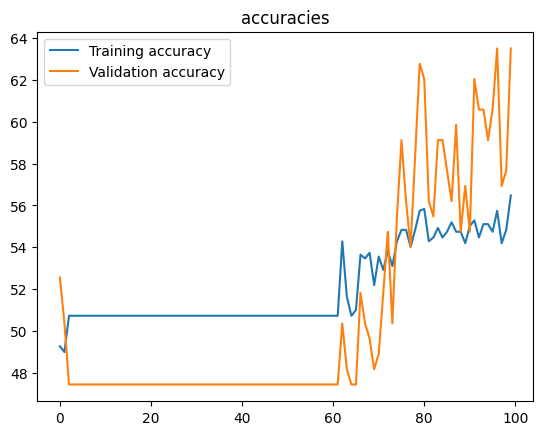

In [7]:
# trainloader = train_loaders[0]
# valloader = val_loaders[0]
# testloader = test_loaders[0]
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = SimpleCNN().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'], configuration['decay'], configuration['dropout'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")


Epoch 1/100

Epoch 2/100

Epoch 3/100

Epoch 4/100

Epoch 5/100

Epoch 6/100

Epoch 7/100

Epoch 8/100

Epoch 9/100

Epoch 10/100

Epoch 11/100

Epoch 12/100

Epoch 13/100

Epoch 14/100

Epoch 15/100

Epoch 16/100

Epoch 17/100

Epoch 18/100

Epoch 19/100

Epoch 20/100

Epoch 21/100

Epoch 22/100

Epoch 23/100

Epoch 24/100

Epoch 25/100

Epoch 26/100

Epoch 27/100

Epoch 28/100

Epoch 29/100

Epoch 30/100

Epoch 31/100

Epoch 32/100

Epoch 33/100

Epoch 34/100

Epoch 35/100

Epoch 36/100

Epoch 37/100

Epoch 38/100

Epoch 39/100

Epoch 40/100

Epoch 41/100

Epoch 42/100

Epoch 43/100

Epoch 44/100

Epoch 45/100

Epoch 46/100

Epoch 47/100

Epoch 48/100

Epoch 49/100

Epoch 50/100

Epoch 51/100

Epoch 52/100

Epoch 53/100

Epoch 54/100

Epoch 55/100

Epoch 56/100

Epoch 57/100

Epoch 58/100

Epoch 59/100

Epoch 60/100

Epoch 61/100

Epoch 62/100

Epoch 63/100

Epoch 64/100

Epoch 65/100

Epoch 66/100

Epoch 67/100

Epoch 68/100

Epoch 69/100

Epoch 70/100

Epoch 71/100

Epoch 72/100



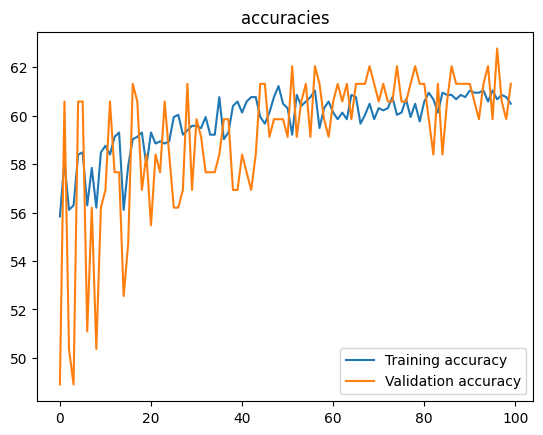

In [8]:
a =  train(net, trainloader, valloader, configuration,  configuration['epochs'], configuration['decay'], configuration['dropout'])


## transfer learning


Epoch 1/100

Epoch 2/100

Epoch 3/100

Epoch 4/100

Epoch 5/100

Epoch 6/100

Epoch 7/100

Epoch 8/100

Epoch 9/100

Epoch 10/100

Epoch 11/100

Epoch 12/100

Epoch 13/100

Epoch 14/100

Epoch 15/100

Epoch 16/100

Epoch 17/100

Epoch 18/100

Epoch 19/100

Epoch 20/100

Epoch 21/100

Epoch 22/100

Epoch 23/100

Epoch 24/100

Epoch 25/100

Epoch 26/100

Epoch 27/100

Epoch 28/100

Epoch 29/100

Epoch 30/100

Epoch 31/100

Epoch 32/100

Epoch 33/100

Epoch 34/100

Epoch 35/100

Epoch 36/100

Epoch 37/100

Epoch 38/100

Epoch 39/100

Epoch 40/100

Epoch 41/100

Epoch 42/100

Epoch 43/100

Epoch 44/100

Epoch 45/100

Epoch 46/100

Epoch 47/100

Epoch 48/100

Epoch 49/100

Epoch 50/100

Epoch 51/100

Epoch 52/100

Epoch 53/100

Epoch 54/100

Epoch 55/100

Epoch 56/100

Epoch 57/100

Epoch 58/100

Epoch 59/100

Epoch 60/100

Epoch 61/100

Epoch 62/100

Epoch 63/100

Epoch 64/100

Epoch 65/100

Epoch 66/100

Epoch 67/100

Epoch 68/100

Epoch 69/100

Epoch 70/100

Epoch 71/100

Epoch 72/100



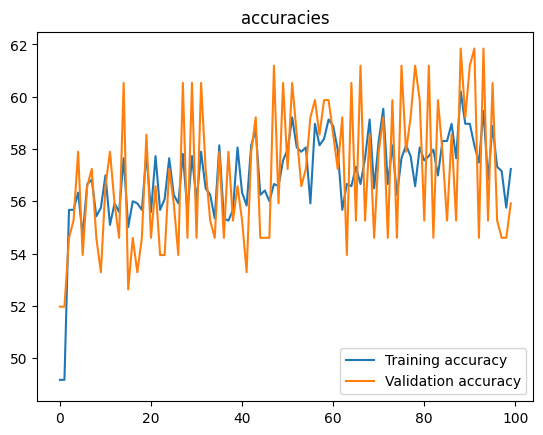

In [9]:
testloader = AZURE[2]
trainloader = AZURE[0]
valloader = AZURE[1]
configuration2={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.1,
    'number of machines': 20
}
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration2, configuration2['epochs'], configuration2['decay'], configuration2['dropout'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = SimpleCNN().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

In [10]:
test(net, testloader, configuration)

(0.2300483783086141, tensor(55.9211, device='cuda:0'))

## Federated Learning

importing azure dataset

In [11]:
for name, val in net.state_dict().items():
    
    print(name)

conv1.weight
conv1.bias
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
conv2.weight
conv2.bias
bn2.weight
bn2.bias
bn2.running_mean
bn2.running_var
bn2.num_batches_tracked
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [12]:
for name, val in net.state_dict().items():
    if ('bn1' not in name and 'bn2' not in name):
        print(name)

'bn1' in 'bn1.bias'

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


True

In [13]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'], configuration['decay_FL'], configuration['dropout'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = SimpleCNN().to(device)
    trainloader = train_loaders[int(cid)]
    valloader = val_loaders[int(cid)]
    return FlowerClient(net, trainloader, valloader, configuration).to_client()


In [14]:

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    net = SimpleCNN().to(device)
    testloader = test_loaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(SimpleCNN())
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=40, no round_timeout
2024-08-09 22:09:44,763	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'node:__internal_head__': 1.0, 'node:192.168.1.146': 1.0, 'memory': 111070212301.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'object_store_memory': 51887233843.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.23111782471338907 / accuracy 50.8982048034668
(ClientAppActor pid=1498132) 
(ClientAppActor pid=1498132) Epoch 1/100
(ClientAppActor pid=1498132)  [repeated 169x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1498132) Epoch 88/100 [repeated 169x across cluster]
(ClientAppActor pid=1498132)  [repeated 163x across cluster]
(ClientAppActor pid=1498132) Epoch 74/100 [repeated 163x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.23030471801757812, {'accuracy': tensor(60.4790, device='cuda:0')}, 14.82646933401702)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.23030471801757812 / accuracy 60.479042053222656
(ClientAppActor pid=1498132)  [repeated 142x across cluster]
(ClientAppActor pid=1498132) Epoch 39/100 [repeated 142x across cluster]
(ClientAppActor pid=1498132)  [repeated 165x across cluster]
(ClientAppActor pid=1498132) Epoch 19/100 [repeated 165x across cluster]
(ClientAppActor pid=1498132)  [repeated 156x across cluster]
(ClientAppActor pid=1498132) Epoch 96/100 [repeated 156x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.22258122762044272, {'accuracy': tensor(73.6527, device='cuda:0')}, 27.47595089301467)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.22258122762044272 / accuracy 73.65269470214844
(ClientAppActor pid=1498132)  [repeated 135x across cluster]
(ClientAppActor pid=1498132) Epoch 53/100 [repeated 135x across cluster]
(ClientAppActor pid=1498132)  [repeated 165x across cluster]
(ClientAppActor pid=1498132) Epoch 28/100 [repeated 165x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.21195038159688315, {'accuracy': tensor(73.6527, device='cuda:0')}, 41.187575739983004)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.21195038159688315 / accuracy 73.65269470214844
(ClientAppActor pid=1498132)  [repeated 138x across cluster]
(ClientAppActor pid=1498132) Epoch 21/100 [repeated 138x across cluster]
(ClientAppActor pid=1498132)  [repeated 166x across cluster]
(ClientAppActor pid=1498132) Epoch 11/100 [repeated 166x across cluster]
(ClientAppActor pid=1498133)  [repeated 179x across cluster]
(ClientAppActor pid=1498133) Epoch 79/100 [repeated 179x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.20569362243016562, {'accuracy': tensor(73.6527, device='cuda:0')}, 53.68304033001186)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.20569362243016562 / accuracy 73.65269470214844
(ClientAppActor pid=1498132)  [repeated 148x across cluster]
(ClientAppActor pid=1498132) Epoch 75/100 [repeated 148x across cluster]
(ClientAppActor pid=1498133)  [repeated 164x across cluster]
(ClientAppActor pid=1498133) Epoch 32/100 [repeated 164x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.20102993647257486, {'accuracy': tensor(74.8503, device='cuda:0')}, 66.45849385898327)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.20102993647257486 / accuracy 74.85029602050781
(ClientAppActor pid=1498132)  [repeated 137x across cluster]
(ClientAppActor pid=1498132) Epoch 13/100 [repeated 137x across cluster]
(ClientAppActor pid=1498132)  [repeated 163x across cluster]
(ClientAppActor pid=1498132) Epoch 93/100 [repeated 163x across cluster]
(ClientAppActor pid=1498132)  [repeated 197x across cluster]
(ClientAppActor pid=1498132) Epoch 90/100 [repeated 197x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.20028074582417807, {'accuracy': tensor(74.8503, device='cuda:0')}, 78.12927870603744)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.20028074582417807 / accuracy 74.85029602050781
(ClientAppActor pid=1498132)  [repeated 154x across cluster]
(ClientAppActor pid=1498132) Epoch 65/100 [repeated 154x across cluster]
(ClientAppActor pid=1498132)  [repeated 154x across cluster]
(ClientAppActor pid=1498132) Epoch 42/100 [repeated 154x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.20113678773244223, {'accuracy': tensor(74.2515, device='cuda:0')}, 91.25184007402277)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.20113678773244223 / accuracy 74.25149536132812
(ClientAppActor pid=1498132)  [repeated 150x across cluster]
(ClientAppActor pid=1498132) Epoch 26/100 [repeated 150x across cluster]
(ClientAppActor pid=1498132)  [repeated 160x across cluster]
(ClientAppActor pid=1498132) Epoch 9/100 [repeated 160x across cluster]
(ClientAppActor pid=1498132)  [repeated 147x across cluster]
(ClientAppActor pid=1498132) Epoch 80/100 [repeated 147x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.1969719926516215, {'accuracy': tensor(76.0479, device='cuda:0')}, 104.68645359500078)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.1969719926516215 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 136x across cluster]
(ClientAppActor pid=1498132) Epoch 41/100 [repeated 136x across cluster]
(ClientAppActor pid=1498132)  [repeated 142x across cluster]
(ClientAppActor pid=1498132) Epoch 2/100 [repeated 142x across cluster]
(ClientAppActor pid=1498132)  [repeated 154x across cluster]
(ClientAppActor pid=1498132) Epoch 85/100 [repeated 154x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.195194939772288, {'accuracy': tensor(76.0479, device='cuda:0')}, 119.00270791200455)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.195194939772288 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 133x across cluster]
(ClientAppActor pid=1498132) Epoch 69/100 [repeated 133x across cluster]
(ClientAppActor pid=1498132)  [repeated 145x across cluster]
(ClientAppActor pid=1498132) Epoch 48/100 [repeated 145x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.1937244733174642, {'accuracy': tensor(75.4491, device='cuda:0')}, 132.55567346903263)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.1937244733174642 / accuracy 75.44910430908203
(ClientAppActor pid=1498132)  [repeated 150x across cluster]
(ClientAppActor pid=1498132) Epoch 6/100 [repeated 150x across cluster]
(ClientAppActor pid=1498132)  [repeated 149x across cluster]
(ClientAppActor pid=1498132) Epoch 73/100 [repeated 149x across cluster]
(ClientAppActor pid=1498132)  [repeated 159x across cluster]
(ClientAppActor pid=1498132) Epoch 54/100 [repeated 159x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.19151494900385538, {'accuracy': tensor(75.4491, device='cuda:0')}, 146.05509566300316)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.19151494900385538 / accuracy 75.44910430908203
(ClientAppActor pid=1498132)  [repeated 139x across cluster]
(ClientAppActor pid=1498132) Epoch 29/100 [repeated 139x across cluster]
(ClientAppActor pid=1498132)  [repeated 164x across cluster]
(ClientAppActor pid=1498132) Epoch 3/100 [repeated 164x across cluster]
(ClientAppActor pid=1498132)  [repeated 171x across cluster]
(ClientAppActor pid=1498132) Epoch 95/100 [repeated 171x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.19050858418146768, {'accuracy': tensor(76.0479, device='cuda:0')}, 158.70853810402332)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.19050858418146768 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 152x across cluster]
(ClientAppActor pid=1498132) Epoch 71/100 [repeated 151x across cluster]
(ClientAppActor pid=1498132)  [repeated 150x across cluster]
(ClientAppActor pid=1498132) Epoch 44/100 [repeated 150x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.1905296246210734, {'accuracy': tensor(76.0479, device='cuda:0')}, 171.61198779201368)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.1905296246210734 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 174x across cluster]
(ClientAppActor pid=1498132) Epoch 41/100 [repeated 174x across cluster]
(ClientAppActor pid=1498132)  [repeated 167x across cluster]
(ClientAppActor pid=1498132) Epoch 35/100 [repeated 167x across cluster]
(ClientAppActor pid=1498133)  [repeated 135x across cluster]
(ClientAppActor pid=1498133) Epoch 72/100 [repeated 135x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.19106843074162802, {'accuracy': tensor(76.0479, device='cuda:0')}, 185.54469474300276)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.19106843074162802 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 139x across cluster]
(ClientAppActor pid=1498132) Epoch 58/100 [repeated 139x across cluster]
(ClientAppActor pid=1498132)  [repeated 156x across cluster]
(ClientAppActor pid=1498132) Epoch 40/100 [repeated 156x across cluster]
(ClientAppActor pid=1498133)  [repeated 129x across cluster]
(ClientAppActor pid=1498133) Epoch 96/100 [repeated 129x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.19050631920496622, {'accuracy': tensor(76.0479, device='cuda:0')}, 199.0421856379835)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.19050631920496622 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 149x across cluster]
(ClientAppActor pid=1498132) Epoch 92/100 [repeated 149x across cluster]
(ClientAppActor pid=1498132)  [repeated 173x across cluster]
(ClientAppActor pid=1498132) Epoch 86/100 [repeated 173x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 0.18813570340474448, {'accuracy': tensor(76.0479, device='cuda:0')}, 212.01474080403568)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18813570340474448 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 152x across cluster]
(ClientAppActor pid=1498132) Epoch 37/100 [repeated 152x across cluster]
(ClientAppActor pid=1498132)  [repeated 191x across cluster]
(ClientAppActor pid=1498132) Epoch 32/100 [repeated 191x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 0.18939046065012613, {'accuracy': tensor(76.0479, device='cuda:0')}, 222.8146725090337)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18939046065012613 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 185x across cluster]
(ClientAppActor pid=1498132) Epoch 28/100 [repeated 185x across cluster]
(ClientAppActor pid=1498132)  [repeated 261x across cluster]
(ClientAppActor pid=1498132) Epoch 75/100 [repeated 261x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 0.18906056880950928, {'accuracy': tensor(77.2455, device='cuda:0')}, 231.119577030011)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18906056880950928 / accuracy 77.2455062866211
(ClientAppActor pid=1498132)  [repeated 275x across cluster]
(ClientAppActor pid=1498132) Epoch 3/100 [repeated 275x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 0.18695072333017984, {'accuracy': tensor(76.0479, device='cuda:0')}, 238.88477880699793)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18695072333017984 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 222x across cluster]
(ClientAppActor pid=1498132) Epoch 4/100 [repeated 222x across cluster]
(ClientAppActor pid=1498132)  [repeated 300x across cluster]
(ClientAppActor pid=1498132) Epoch 56/100 [repeated 300x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (20, 0.18734633922576904, {'accuracy': tensor(76.0479, device='cuda:0')}, 245.6342071199906)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18734633922576904 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 292x across cluster]
(ClientAppActor pid=1498132) Epoch 18/100 [repeated 292x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 0.18657100200653076, {'accuracy': tensor(76.0479, device='cuda:0')}, 253.18820822803536)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18657100200653076 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 266x across cluster]
(ClientAppActor pid=1498132) Epoch 34/100 [repeated 266x across cluster]
(ClientAppActor pid=1498132)  [repeated 310x across cluster]
(ClientAppActor pid=1498132) Epoch 92/100 [repeated 310x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 0.18667248884836832, {'accuracy': tensor(76.6467, device='cuda:0')}, 259.915574602026)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18667248884836832 / accuracy 76.6467056274414
(ClientAppActor pid=1498132)  [repeated 270x across cluster]
(ClientAppActor pid=1498132) Epoch 21/100 [repeated 269x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (23, 0.19008952379226685, {'accuracy': tensor(74.2515, device='cuda:0')}, 266.8442966330331)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.19008952379226685 / accuracy 74.25149536132812
(ClientAppActor pid=1498132)  [repeated 294x across cluster]
(ClientAppActor pid=1498132) Epoch 82/100 [repeated 294x across cluster]
(ClientAppActor pid=1498133)  [repeated 257x across cluster]
(ClientAppActor pid=1498133) Epoch 92/100 [repeated 257x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 0.1847361922264099, {'accuracy': tensor(76.6467, device='cuda:0')}, 274.7424093710142)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.1847361922264099 / accuracy 76.6467056274414
(ClientAppActor pid=1498132)  [repeated 275x across cluster]
(ClientAppActor pid=1498132) Epoch 59/100 [repeated 275x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (25, 0.18500224749247232, {'accuracy': tensor(76.6467, device='cuda:0')}, 282.21362278802553)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18500224749247232 / accuracy 76.6467056274414
(ClientAppActor pid=1498132)  [repeated 264x across cluster]
(ClientAppActor pid=1498132) Epoch 82/100 [repeated 264x across cluster]
(ClientAppActor pid=1498133)  [repeated 251x across cluster]
(ClientAppActor pid=1498133) Epoch 82/100 [repeated 251x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (26, 0.18419510126113892, {'accuracy': tensor(77.2455, device='cuda:0')}, 290.19100273103686)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18419510126113892 / accuracy 77.2455062866211
(ClientAppActor pid=1498132)  [repeated 284x across cluster]
(ClientAppActor pid=1498132) Epoch 37/100 [repeated 284x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (27, 0.18390554189682007, {'accuracy': tensor(76.0479, device='cuda:0')}, 297.06615243898705)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18390554189682007 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 283x across cluster]
(ClientAppActor pid=1498132) Epoch 72/100 [repeated 283x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 0.18308478593826294, {'accuracy': tensor(76.6467, device='cuda:0')}, 303.7542294570012)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18308478593826294 / accuracy 76.6467056274414
(ClientAppActor pid=1498132)  [repeated 305x across cluster]
(ClientAppActor pid=1498132) Epoch 35/100 [repeated 305x across cluster]
(ClientAppActor pid=1498133)  [repeated 300x across cluster]
(ClientAppActor pid=1498133) Epoch 54/100 [repeated 300x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 0.1844878395398458, {'accuracy': tensor(77.2455, device='cuda:0')}, 311.3986795429955)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.1844878395398458 / accuracy 77.2455062866211
(ClientAppActor pid=1498132)  [repeated 242x across cluster]
(ClientAppActor pid=1498132) Epoch 17/100 [repeated 242x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (30, 0.18443745374679565, {'accuracy': tensor(76.6467, device='cuda:0')}, 319.02820113598136)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18443745374679565 / accuracy 76.6467056274414
(ClientAppActor pid=1498132)  [repeated 266x across cluster]
(ClientAppActor pid=1498132) Epoch 36/100 [repeated 266x across cluster]
(ClientAppActor pid=1498132)  [repeated 300x across cluster]
(ClientAppActor pid=1498132) Epoch 95/100 [repeated 300x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (31, 0.18419528007507324, {'accuracy': tensor(74.8503, device='cuda:0')}, 326.0103837320348)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18419528007507324 / accuracy 74.85029602050781
(ClientAppActor pid=1498132)  [repeated 268x across cluster]
(ClientAppActor pid=1498132) Epoch 14/100 [repeated 268x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (32, 0.18380371729532877, {'accuracy': tensor(76.6467, device='cuda:0')}, 332.7993686480331)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18380371729532877 / accuracy 76.6467056274414
(ClientAppActor pid=1498132)  [repeated 305x across cluster]
(ClientAppActor pid=1498132) Epoch 74/100 [repeated 305x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (33, 0.18335084120432535, {'accuracy': tensor(75.4491, device='cuda:0')}, 339.48319869302213)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18335084120432535 / accuracy 75.44910430908203
(ClientAppActor pid=1498132)  [repeated 291x across cluster]
(ClientAppActor pid=1498132) Epoch 15/100 [repeated 291x across cluster]
(ClientAppActor pid=1498132)  [repeated 304x across cluster]
(ClientAppActor pid=1498132) Epoch 71/100 [repeated 304x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (34, 0.1823994517326355, {'accuracy': tensor(76.0479, device='cuda:0')}, 346.4531692180317)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.1823994517326355 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 299x across cluster]
(ClientAppActor pid=1498132) Epoch 25/100 [repeated 299x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (35, 0.18274521827697754, {'accuracy': tensor(75.4491, device='cuda:0')}, 353.2983769940329)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18274521827697754 / accuracy 75.44910430908203
(ClientAppActor pid=1498132)  [repeated 280x across cluster]
(ClientAppActor pid=1498132) Epoch 53/100 [repeated 280x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (36, 0.18421332041422525, {'accuracy': tensor(76.6467, device='cuda:0')}, 359.71188498300035)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18421332041422525 / accuracy 76.6467056274414
(ClientAppActor pid=1498132)  [repeated 322x across cluster]
(ClientAppActor pid=1498132) Epoch 20/100 [repeated 322x across cluster]
(ClientAppActor pid=1498133)  [repeated 333x across cluster]
(ClientAppActor pid=1498133) Epoch 64/100 [repeated 333x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (37, 0.18276484807332358, {'accuracy': tensor(75.4491, device='cuda:0')}, 366.3305343450047)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18276484807332358 / accuracy 75.44910430908203
(ClientAppActor pid=1498132)  [repeated 286x across cluster]
(ClientAppActor pid=1498132) Epoch 23/100 [repeated 286x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (38, 0.18549625078837076, {'accuracy': tensor(77.2455, device='cuda:0')}, 372.442143694032)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18549625078837076 / accuracy 77.2455062866211
(ClientAppActor pid=1498132)  [repeated 328x across cluster]
(ClientAppActor pid=1498132) Epoch 88/100 [repeated 328x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (39, 0.18455741802851358, {'accuracy': tensor(76.0479, device='cuda:0')}, 378.55816331401)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.18455741802851358 / accuracy 76.04790496826172
(ClientAppActor pid=1498132)  [repeated 342x across cluster]
(ClientAppActor pid=1498132) Epoch 70/100 [repeated 342x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (40, 0.18500099579493204, {'accuracy': tensor(76.6467, device='cuda:0')}, 385.19965571002103)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 40 rounds in 385.23s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.1975485852786473\n'
INFO :      	 '\tround 2: 0.22204802433649698\n'
INFO :      	 '\tround 3: 0.2042383054892222\n'
INFO :      	 '\tround 4: 0.1709546446800232\n'
INFO :      	 '\tround 5: 0.17289468220302037\n'
INFO :      	 '\tround 6: 0.17332016570227488\n'
INFO :      	 '\tround 7: 0.17080421958650863\n'
INFO :      	 '\tround 8: 0.16858298437935965\n'
INFO :      	 '\tround 9: 0.16988611221313477\n'
INFO :      	 '\tround 10: 0.17501323563711985\n'
INFO :      	 '\tround 11: 0.19394806027412415\n'
INFO :      	 '\tround 

Server-side evaluation loss 0.18500099579493204 / accuracy 76.6467056274414


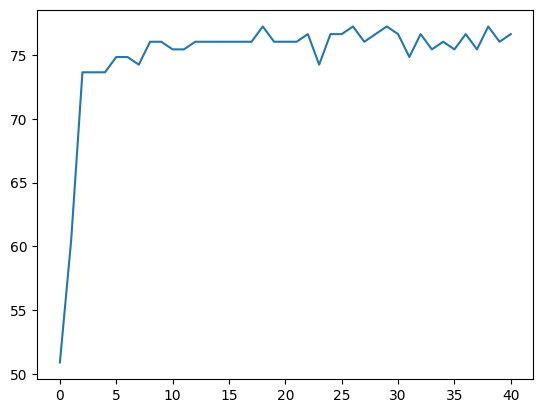

In [15]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
def weighted_average(metrics) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    # client_resources=client_resources,
)

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=fl.server.strategy.FedAvg(),
    client_resources=client_resources
)